## xgboost results

This notebook contains the results from xgboost.

- XGBoost was first optmized with a very small grid (trees and learning rate)
- afterwards the selected features were used within a larger grid search space

We want to have the following results:
1. Results of the cross-validation
2. Results of the train / test split
3. SHAP results
4. interactions
5. target / decoys

Methods:
TBD

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import glob
shap.initjs()
# load the results from no feature selection
data_dic = pickle.load(open(r"..\results\xifaims_8PM4PM_CO_NAVG_huge_nofeats.p", "rb"))
# data dictionary contains results from running
print(data_dic.keys())



dict_keys(['best_features_gs', 'summary_gs', 'best_params_gs', 'xifaims_params', 'xifaims_config', 'xgb', 'predictions_df', 'data', 'metrics', 'df_unique', 'df_nonunique'])

In [3]:
# takes very long?!
# get the summary metric data from all pickle files
#files = glob.glob(r"..\results\*.p")
#data_overview = []
#for i in files:
#    df_tmp = i.load(open(r"..\results\xifaims_8PM4PM_OH_AVG_tiny.p", "rb"))["metrics"]
#    df_tmp["file"] = i
#    data_overview.append(df_tmp)
#df_data_overview = pd.concat(data_overview)
#df_data_overview

## Train-Test Split

The following table summarizes the metrics for training on 80% of the data and then predicting on the other 20%.


In [2]:
metrics_df = data_dic["metrics"]
metrics_df = metrics_df.round(2)
metrics_df = metrics_df.set_index("split")
metrics_df

,r2,pearsonr,MAE,MSE
split,,,,
Train,0.83,0.92,3.66,22.08
Validation,0.49,0.70,6.40,69.51
DX,0.40,0.68,5.56,50.80


## Best features:

Using mlxtend and the nested SequentialFeatureSelector + GridSearch the following features get choosen through a parsimony criterium:

In [3]:
features = data_dic["best_features_gs"]
print(features)

print(data_dic["best_params_gs"])

Index(['length1', 'length2', 'length1+length2', 'mass', 'loop', 'oh', 'nh2',
       'p.charge', 'aromatics', 'helix', 'sheet', 'turn', 'pi', 'charge_glob',
       'charge_density', 'hydrophobic_ratio', 'intrinsic_size_sum',
       'intrinsic_size_std', 'intrinsic_size_max', 'mv_sum', 'mv_size_std',
       'mv_size_max', 'polarity_sum', 'polarity_size_std', 'polarity_size_max',
       'secondstruc_sum', 'secondstruc_size_std', 'secondstruc_size_max',
       'estatic_sum', 'sstatic_size_std', 'static_size_max', 'm/z'],
      dtype='object')
{'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 100, 'nthread': 1, 'reg_alpha': 0.01, 'reg_lambda': 0.1, 'seed': 42, 'subsample': 0.8}


# Cross-validation results

The CV was done using 3splits and negative_mean_squared_error as metric.

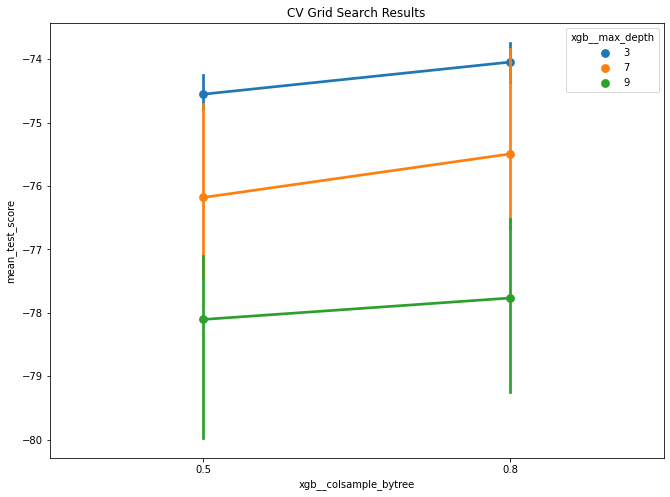

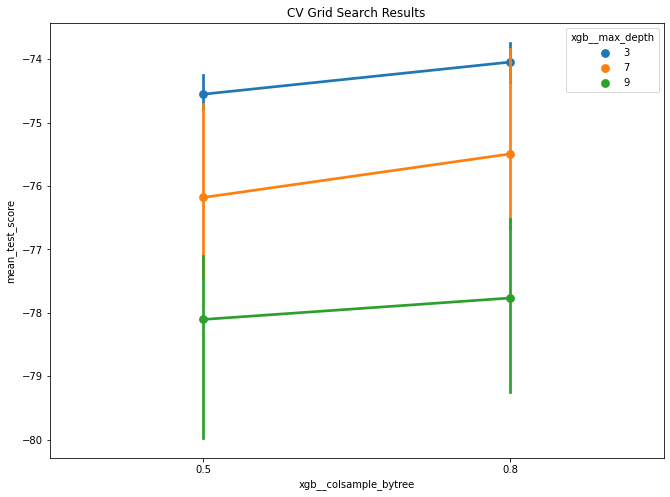

In [4]:
df_cv = data_dic["summary_gs"]
df_cv = df_cv.sort_values("rank_test_score", ascending=True)
df_cv.filter(regex="param|rank", axis=1).head(20)

def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    #cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return fig


plot_cv_results(df_cv, "xgb__colsample_bytree", "xgb__max_depth")

In [7]:
best_cv = df_cv
best_cv
#print(best_cv)
best_df = df_cv.filter(regex="split|rank")
best_df


,split0_test_score,split1_test_score,split2_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score
667,-62.397732,-71.496730,-68.558133,1,-19.034339,-17.401423,-17.733205
955,-62.397732,-71.496730,-68.558133,1,-19.034339,-17.401423,-17.733205
631,-62.132326,-73.129079,-67.333941,3,-20.265831,-20.767012,-20.968744
647,-62.132326,-73.129079,-67.333941,3,-20.265831,-20.767012,-20.968744
659,-63.113706,-71.650306,-67.969708,5,-30.415842,-28.429399,-28.129498
...,...,...,...,...,...,...,...
266,-92.288469,-100.798415,-94.848413,1147,-1.164166,-0.946695,-1.232763
1116,-92.226431,-98.962893,-99.951302,1149,-0.581206,-0.663606,-0.741282
1132,-92.226431,-98.962893,-99.951302,1149,-0.581206,-0.663606,-0.741282
1128,-94.666893,-100.407697,-97.357692,1151,-0.626944,-0.608034,-0.803112


In [8]:
res_melt = best_df.melt(id_vars=["rank_test_score"])
res_melt = res_melt[res_melt["rank_test_score"] == 1]
res_melt["Split"] = ["Train" if "train" in i else "Test" for i in res_melt["variable"]]
res_melt



,rank_test_score,variable,value,Split
0,1,split0_test_score,-62.397732,Test
1,1,split0_test_score,-62.397732,Test
1152,1,split1_test_score,-71.496730,Test
1153,1,split1_test_score,-71.496730,Test
2304,1,split2_test_score,-68.558133,Test
2305,1,split2_test_score,-68.558133,Test
3456,1,split0_train_score,-19.034339,Train
3457,1,split0_train_score,-19.034339,Train
4608,1,split1_train_score,-17.401423,Train
4609,1,split1_train_score,-17.401423,Train


## Train - Validation Evaluation

Evaluate the results when the model was trained on 80%.

In [5]:
predictions_df = data_dic["predictions_df"]
predictions_df.Split.unique()
predictions_df["Split"] = predictions_df["Split"].str.replace("Test", "Validation")
predictions_df
predictions_df["diff"] = predictions_df["predictions"] -  predictions_df["observed"]
predictions_df["diff_abs"] = np.abs(predictions_df["predictions"] -  predictions_df["observed"])
predictions_df["Split"] = [f"{i} ({metrics_df.loc[i]['pearsonr']})" for i in predictions_df["Split"]]
predictions_df.head()



,predictions,observed,Split,diff,diff_abs
0,-55.783409,-55.310786,Train (0.92),-0.472623,0.472623
1,-42.984631,-44.892079,Train (0.92),1.907448,1.907448
2,-53.424168,-60.705007,Train (0.92),7.280839,7.280839
3,-56.909737,-55.871504,Train (0.92),-1.038233,1.038233
4,-39.379372,-40.430091,Train (0.92),1.050719,1.050719


<AxesSubplot:xlabel='Split', ylabel='diff'>

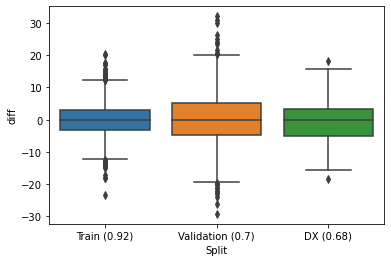

In [6]:
sns.boxplot(x="Split", y="diff", data=predictions_df)

<AxesSubplot:xlabel='Split', ylabel='diff_abs'>

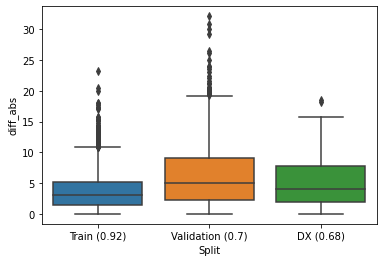

In [7]:
sns.boxplot(x="Split", y="diff_abs", data=predictions_df)

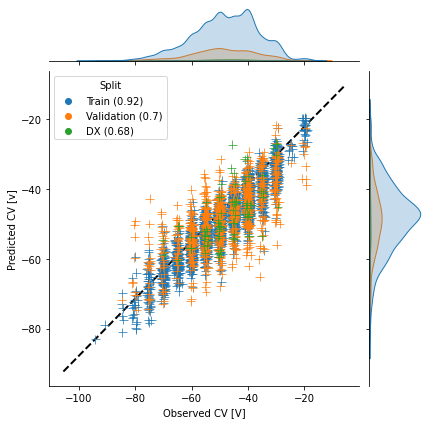

In [8]:
#fax = sns.jointplot(y="predictions", x="observed", hue="Split", data=predictions_df[predictions_df["Split"] != "DX"], marker="+", s=50)
fax = sns.jointplot(y="predictions", x="observed", hue="Split", data=predictions_df, marker="+", s=80)
fax.ax_joint.set(xlabel="Observed CV [V]", ylabel="Predicted CV [v]")
x0, x1 = fax.ax_joint.get_xlim()
y0, y1 = fax.ax_joint.get_ylim()
fax.ax_joint.plot([x0, x1], [y0, y1], ls="--", zorder=-1, lw=2, c="k")



### SHAP Analysis
Use shap to determine:
1. most important parameters
2. interesting interactions

In [9]:
print("Loading model, train, val, dx features and best features")
# model
model = data_dic["xgb"]
print(data_dic["data"].keys())

# data consists of tuples with meta data and feature data
all_data = data_dic["data"]
TT_train, TT_train_features, TT_predictions = all_data["TT_train"] 
TT_val, TT_val_features, TT_val_predictions = all_data["TT_val"] 
DX = all_data["DX"] 
#print(all_data)

# use shortcut
X = TT_val_features[features]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_values_inter = shap.TreeExplainer(model).shap_interaction_values(X)

Loading model, train, val, dx features and best features
dict_keys(['TT_train', 'TT_val', 'DX'])


<AxesSubplot:xlabel='SHAP value (impact on model output)'>

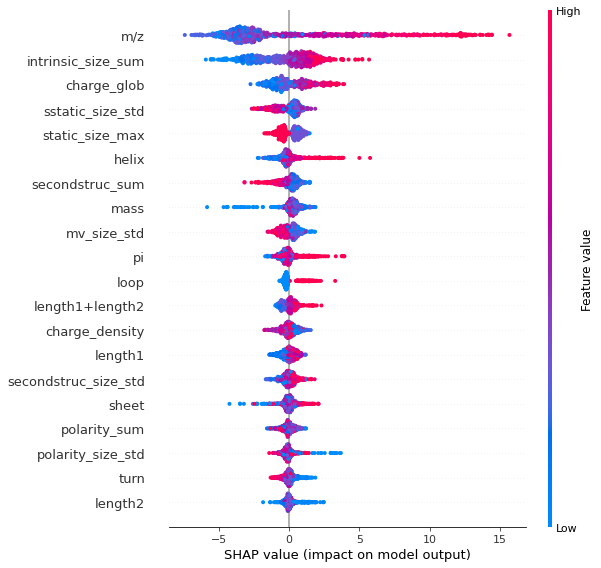

In [10]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X, show=False)
fig = plt.gcf()
ax = plt.gca()
ax

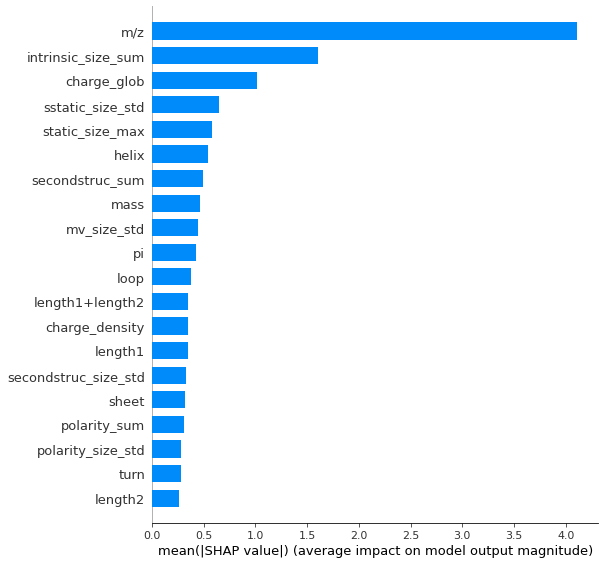

In [15]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [11]:
# shap viz
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [17]:
shap.force_plot(explainer.expected_value, shap_values, X)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


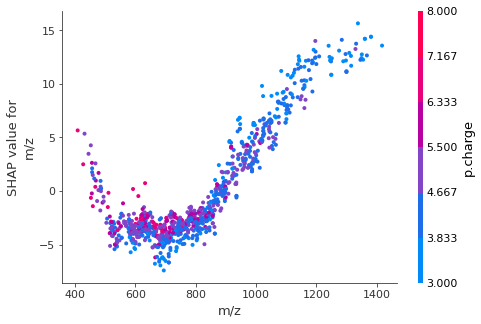

In [18]:
shap.dependence_plot("m/z", shap_values, X)

## Final Figure


In [19]:
res_melt

,rank_test_score,variable,value,Split
0,1,split0_test_score,-62.397732,Test
1,1,split0_test_score,-62.397732,Test
1152,1,split1_test_score,-71.496730,Test
1153,1,split1_test_score,-71.496730,Test
2304,1,split2_test_score,-68.558133,Test
2305,1,split2_test_score,-68.558133,Test
3456,1,split0_train_score,-19.034339,Train
3457,1,split0_train_score,-19.034339,Train
4608,1,split1_train_score,-17.401423,Train
4609,1,split1_train_score,-17.401423,Train


      rank_test_score            variable      value  Split
0                   1   split0_test_score -62.397732   Test
1152                1   split1_test_score -71.496730   Test
2304                1   split2_test_score -68.558133   Test
3456                1  split0_train_score -19.034339  Train
4608                1  split1_train_score -17.401423  Train
5760                1  split2_train_score -17.733205  Train


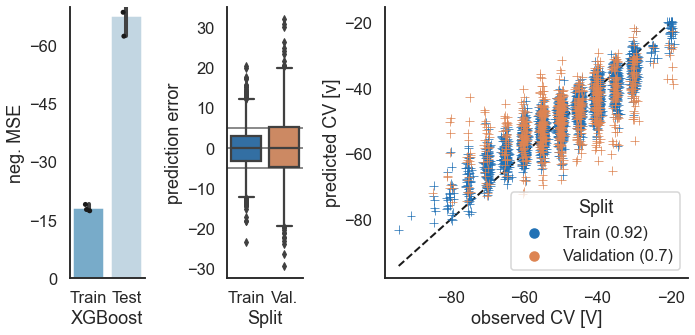

In [20]:
from matplotlib import ticker
predictions_df_TV = predictions_df[~predictions_df["Split"].str.contains("DX")]
order_cor = predictions_df_TV["Split"].unique()
res_melt = res_melt.drop_duplicates()
train_cv_col = "#6baed6"
test_col =  "#bdd7e7"

# 80%20 splits
val_col = "C1"
train_col = "#2171b5"

sns.set(style="white", context="talk")
gridspec_kw={'width_ratios':[0.25, 0.25,  1]}
f, (ax0, ax2, ax1) = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw=gridspec_kw)
print(res_melt)
# bar plot
ax0 = sns.barplot(x="Split", y="value", data=res_melt, ax=ax0, order=["Train", "Test"], palette={"Train": train_cv_col, "Test": test_col})
ax0 = sns.stripplot(x="Split", y="value", data=res_melt, ax=ax0, order=["Train", "Test"], color="k")
ax0.set_ylim(0, -70)
ax0.set(xlabel="XGBoost", ylabel="neg. MSE")
ax0.yaxis.set_major_locator(ticker.MaxNLocator(5))
sns.despine(ax=ax0)


ax2 = sns.boxplot(x="Split", y="diff", data=predictions_df_TV, ax=ax2, palette={order_cor[0]: train_col, order_cor[1]: val_col})
ax2.axhline(0, lw=2, c="k", zorder=-1, alpha=0.5)
ax2.set(xticklabels=["Train", "Val."], ylabel="prediction error")
ax2.axhline(5, lw=2, c="k", zorder=-1, alpha=0.5)
ax2.axhline(-5, lw=2, c="k", zorder=-1, alpha=0.5)
sns.despine(ax=ax2)

ax1 = sns.scatterplot(y="predictions", x="observed", hue="Split", data=predictions_df_TV, marker="+", s=80, ax=ax1, palette={order_cor[0]: train_col, order_cor[1]: val_col})
xmin = predictions_df_TV[["predictions", "observed"]].min().min()
xmax = predictions_df_TV[["predictions", "observed"]].max().max()
ax1.plot([xmin, xmax], [xmin, xmax], ls="--", zorder=-1, lw=2, c="k")
ax1.set(xlabel="observed CV [V]", ylabel="predicted CV [v]")
ax1.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax1.xaxis.set_major_locator(ticker.MaxNLocator(5))
sns.despine(ax=ax1)

plt.tight_layout()
f.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Fig2abc_ml_overvew.png")
f.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Fig2abc_ml_overvew.svg")
f.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Fig2abc_ml_overvew.pdf")

#ax2 = sns.barplot(x="Split", y="value", data=res_melt, ax=ax0, order=["train", "test"])
#ax3 = sns.scatterplot(y="predictions", x="observed", hue="Split", data=predictions_df, marker="+", s=80, ax=ax3)


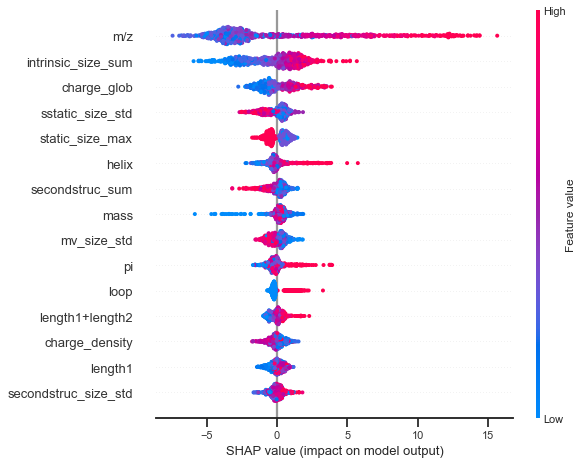

In [21]:
#%%
# retrieve the shap plot from above
plt.clf()
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
shap.summary_plot(shap_values, X, show=False, max_display=15)
ax2 = plt.gca()
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Fig2d_shap_overall.png", dpi=1200)
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Fig2d_shap_overall.svg", format='svg', dpi=1200)
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Fig2d_shap_overall.pdf", dpi=1200)
#ax2.set(xlabel="test")
#ax4 = plt.gca()




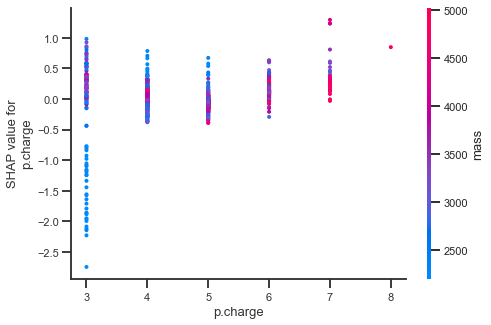

In [31]:
shap.dependence_plot("p.charge", shap_values, X, show=False, interaction_index="mass")
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Fig2e_shap_z_mass_interaction.png", dpi=1200)
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Fig2e_shap_z_mass_interaction.svg", format='svg', dpi=1200)
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Fig2e_shap_z_mass_interaction.pdf", dpi=1200)
#ax3 = plt.gca()
#ax1 = ax3

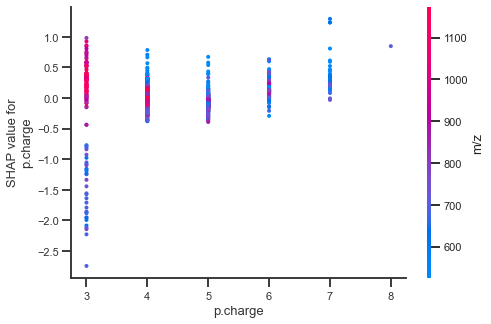

In [23]:
shap.dependence_plot("p.charge", shap_values, X, show=False, interaction_index="m/z")
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Fig2e_shap_z_mz_interaction.png", dpi=1200)
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Fig2e_shap_z_mz_interaction.svg", format='svg', dpi=1200)
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Fig2e_shap_z_mz_interaction.pdf", dpi=1200)
#ax3 = plt.gca()
#ax1 = ax3

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


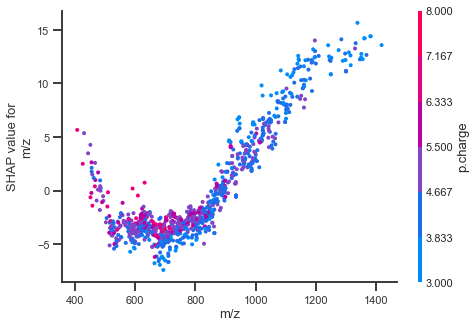

In [24]:
shap.dependence_plot("m/z", shap_values, X, show=False)
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Suppfig_SHAP_interaction_mz.png", dpi=1200)
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Suppfig_SHAP_interaction_mz.svg", format='svg', dpi=1200)
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Suppfig_SHAP_interaction_mz.pdf", dpi=1200)

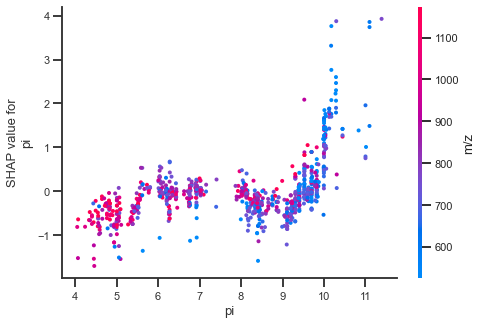

In [29]:
shap.dependence_plot("pi", shap_values, X, show=False, interaction_index="m/z")
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Suppfig_SHAP_interaction_mz_pi.png", dpi=1200)
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Suppfig_SHAP_interaction_mz_pi.svg", format='svg', dpi=1200)
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Suppfig_SHAP_interaction_mz_pi.pdf", dpi=1200)

### check variable importance for z=3 vsz=4

In [25]:
z3 = VAL_meta[VAL_meta["exp charge"] == 3].index
z3_X = VAL_meta["exp charge"] == 3

z4 = VAL_meta[VAL_meta["exp charge"] == 4].index
z4_X = VAL_meta["exp charge"] == 4

shap.summary_plot(shap_values[z3.values], X.reset_index(drop=True).loc[z3.values], show=False, max_display=20)
plt.show()

shap.summary_plot(shap_values[z4.values], X.reset_index(drop=True).loc[z4.values], show=False, max_display=20)
plt.show()

NameError: name 'VAL_meta' is not defined

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


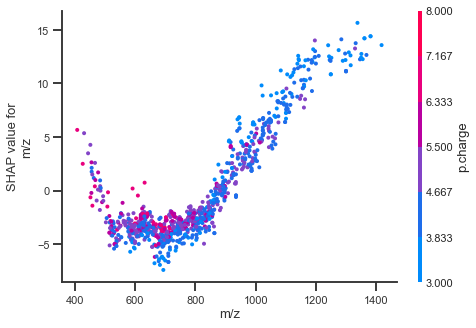

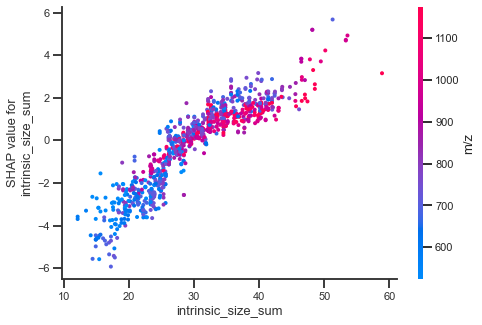

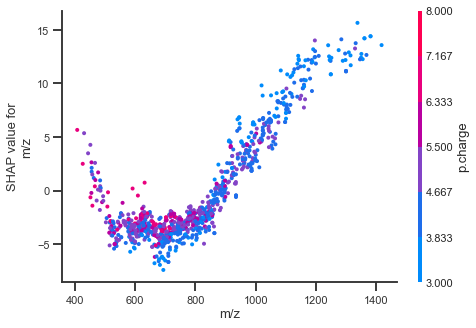

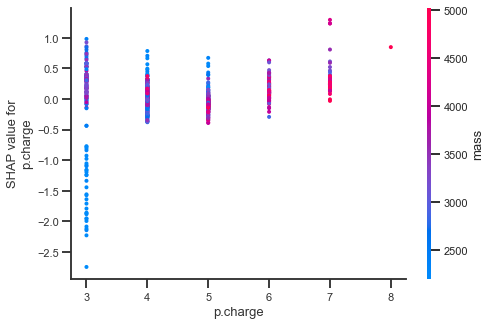

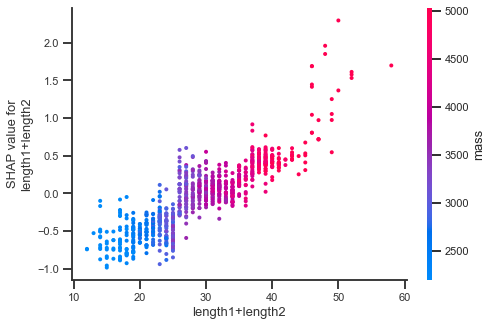

In [176]:
shap.dependence_plot("m/z", shap_values, X, show=False)
shap.dependence_plot("intrinsic_size_sum", shap_values, X, show=False)
shap.dependence_plot("m/z", shap_values, X, show=False)
shap.dependence_plot("p.charge", shap_values, X, show=False, interaction_index="mass")
shap.dependence_plot("length1+length2", shap_values, X, show=False, interaction_index="mass")



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


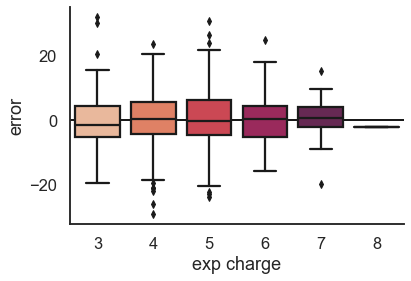

<Figure size 432x288 with 0 Axes>

In [198]:
# check if the prediction error, behaves differently for different charge states
from scipy.stats import f_oneway
filter_str = predictions_df["Split"].unique()[1]
predictions_df = data_dic["predictions_df"]
predictions_df_val = predictions_df[predictions_df["Split"] == filter_str]
predictions_df_val["error"] = (predictions_df_val["predictions"] - predictions_df_val["observed"]).values

TT_meta, TT_features, TT_preds = data_dic["data"]["TT_train"]
VAL_meta, VAL_features, VAL_preds = data_dic["data"]["TT_val"]
VAL_meta["error"] = predictions_df_val["error"].values
VAL_meta = VAL_meta.reset_index()

f, ax = plt.subplots(1, figsize=(6, 4))
ax = sns.boxplot(x="exp charge", y="error", data=VAL_meta, palette="rocket_r")
ax.axhline(0, lw=2, c="k", zorder=-1)
sns.despine()
plt.show()
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Suppfig_errors_chargestate.png")
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Suppfig_errors_chargestate.pdf")
plt.savefig(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Suppfig_errors_chargestate.svg")

### Some Stats

Check if the error distributions are different between different charge states. Use anova to first find if there is a difference between groups (at all). If so, use tukey test for all pairs to determine the sig. contributions.    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    from scipy.stats import f_oneway
    anova_result = f_oneway(*[VAL_meta[VAL_meta["exp charge"] == i]["error"].values for i in
                              VAL_meta["exp charge"].unique()])
    print("Anova:", anova_result)

    print(VAL_meta["exp charge"].value_counts())
    # perform multiple pairwise comparison (Tukey HSD)
    m_comp = pairwise_tukeyhsd(endog=VAL_meta['error'], groups=VAL_meta['exp charge'], alpha=0.05)
    tukey_data = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
    tukey_data = tukey_data.sort_values("p-adj")
    print(tukey_data)

In [199]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway
anova_result = f_oneway(*[VAL_meta[VAL_meta["exp charge"] == i]["error"].values for i in
                          VAL_meta["exp charge"].unique()])
print("Anova:", anova_result)

print(VAL_meta["exp charge"].value_counts())
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=VAL_meta['error'], groups=VAL_meta['exp charge'], alpha=0.01)
tukey_data = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
tukey_data = tukey_data.sort_values("p-adj")
tukey_data
tukey_data.to_excel(r"F:\Sven\CloudStorage\Dropbox\05_FAIMS in CLMS\03_figures\10_Manuscript_figs\fig_2_SG\Supptable_statistical_tests_anova_pval099.xlsx")

Anova: F_onewayResult(statistic=0.04912479309123448, pvalue=0.9985371056433061)
4    358
5    250
3    123
6    109
7     46
8      1
Name: exp charge, dtype: int64


In [181]:
print(data_dic["best_params_gs"])
features = data_dic["best_features_gs"]
print(features)
print(len(features))

{'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 100, 'nthread': 1, 'reg_alpha': 0.01, 'reg_lambda': 0.1, 'seed': 42, 'subsample': 0.8}
Index(['length1', 'length2', 'length1+length2', 'mass', 'loop', 'oh', 'nh2',
       'p.charge', 'aromatics', 'helix', 'sheet', 'turn', 'pi', 'charge_glob',
       'charge_density', 'hydrophobic_ratio', 'intrinsic_size_sum',
       'intrinsic_size_std', 'intrinsic_size_max', 'mv_sum', 'mv_size_std',
       'mv_size_max', 'polarity_sum', 'polarity_size_std', 'polarity_size_max',
       'secondstruc_sum', 'secondstruc_size_std', 'secondstruc_size_max',
       'estatic_sum', 'sstatic_size_std', 'static_size_max', 'm/z'],
      dtype='object')
32


 # analysis by LS

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


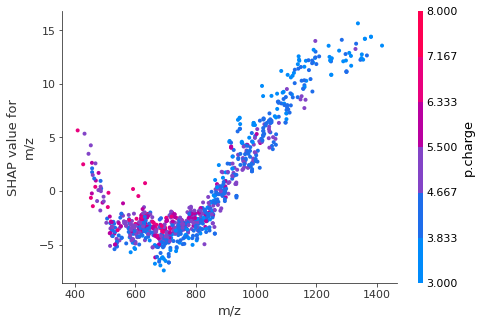

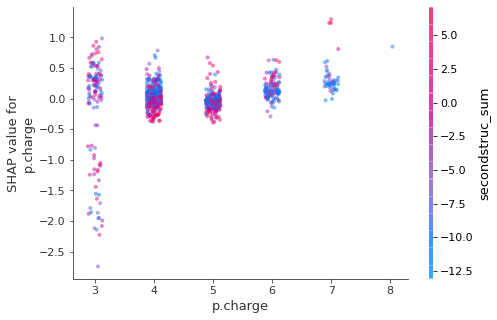

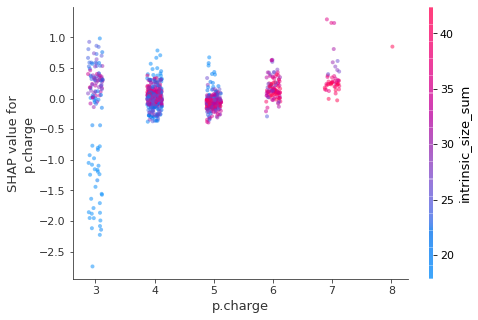

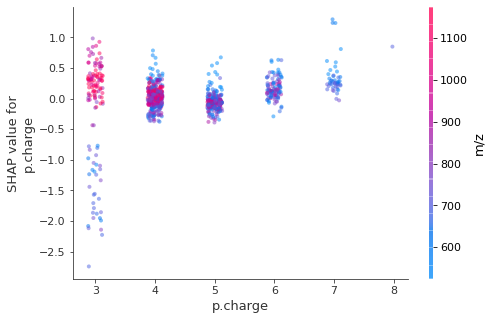

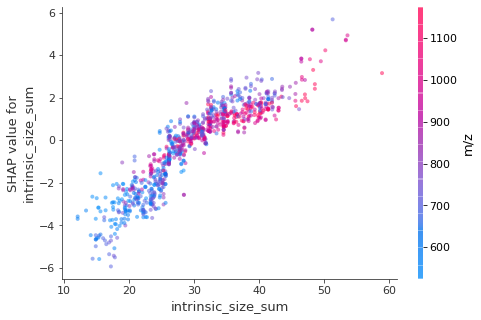

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


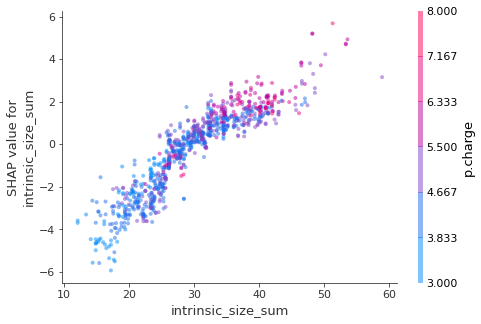

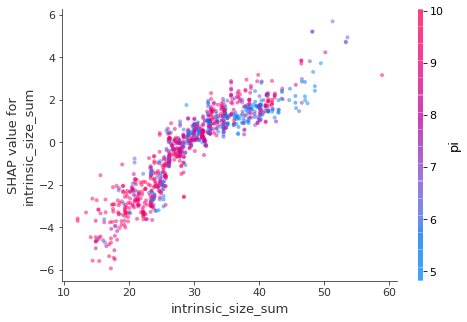

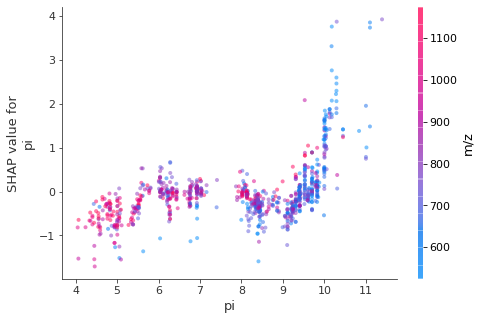

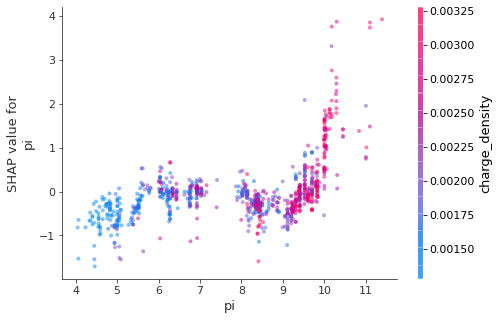

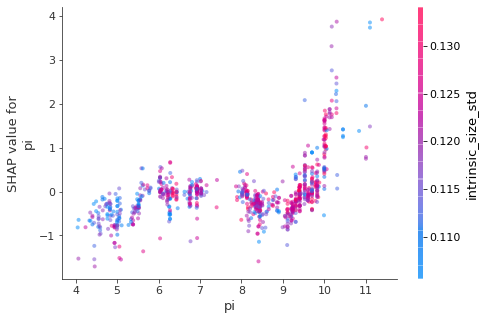

In [12]:
shap.dependence_plot("m/z", shap_values, X)

# LS, 201218
# we can use shap.approximate_interactions to guess which features may interact with p-charge
inds = shap.approximate_interactions("p.charge", shap_values, X)

# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.dependence_plot("p.charge", shap_values, X, x_jitter=0.25, interaction_index=inds[i], alpha=0.5)

# features may interact with intrinsic_size
inds = shap.approximate_interactions("intrinsic_size_sum", shap_values, X)

# plot top three possible interacting features with intrinsic_size
for i in range(3):
    shap.dependence_plot("intrinsic_size_sum", shap_values, X, interaction_index=inds[i], alpha=0.5)

 # features may interact with pI
inds = shap.approximate_interactions("pi", shap_values, X)

# plot top three possible interacting features
for i in range(3):
    shap.dependence_plot("pi", shap_values, X, interaction_index=inds[i], alpha=0.5)